# Compression Report - Window half dataset - One dimension

In [1]:
import os
import json 
import subprocess
import importlib

import xbitinfo as xb
import xarray as xr

import utils

In [2]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

In [ ]:
# load changes without restarting the notebook
importlib.reload(utils);

---

In [3]:
# load data
path_to_data = 'data/data-t2m-sp-tp-2023-mai-0112.nc'  # change this
ds = xr.open_dataset(path_to_data)

In [4]:
ds

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, time: 1)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2023-05-01T12:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 ...
    sp         (time, latitude, longitude) float32 ...
    tp         (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-05-15 22:53:25 GMT by grib_to_netcdf-2.30.0: grib_to_n...

  0%|          | 0/3 [00:00<?, ?it/s]

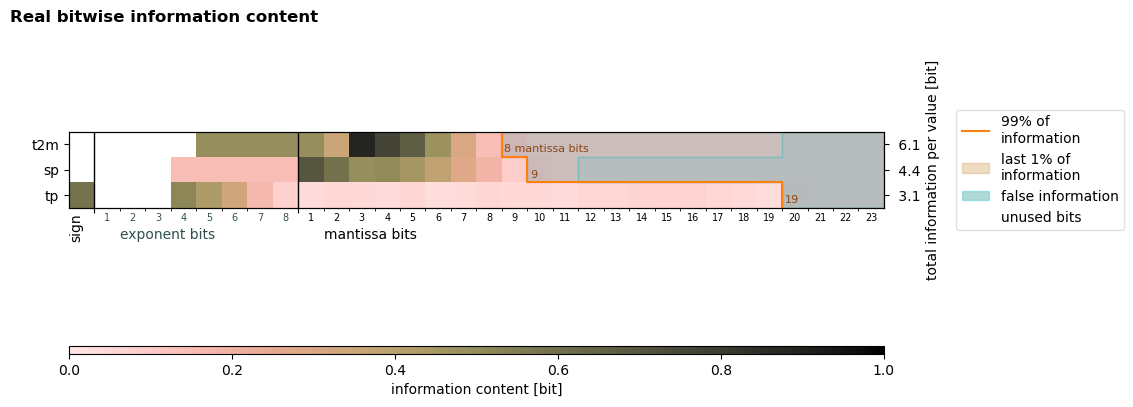

In [5]:
# get information content per bit
info_per_bit = xb.get_bitinformation(ds, dim='latitude', implementation="python")

fig = xb.plot_bitinformation(info_per_bit)

In [6]:
# get keepbits
keepbits = xb.get_keepbits(info_per_bit, 0.99)

In [7]:
# apply bitrounding
ds_bitrounded = xb.xr_bitround(ds, keepbits)

---

In [8]:
PARTS = 2
var = 'latitude'
dss = []
dss_bitrounded = []

chunk = ds[var].size // 2

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

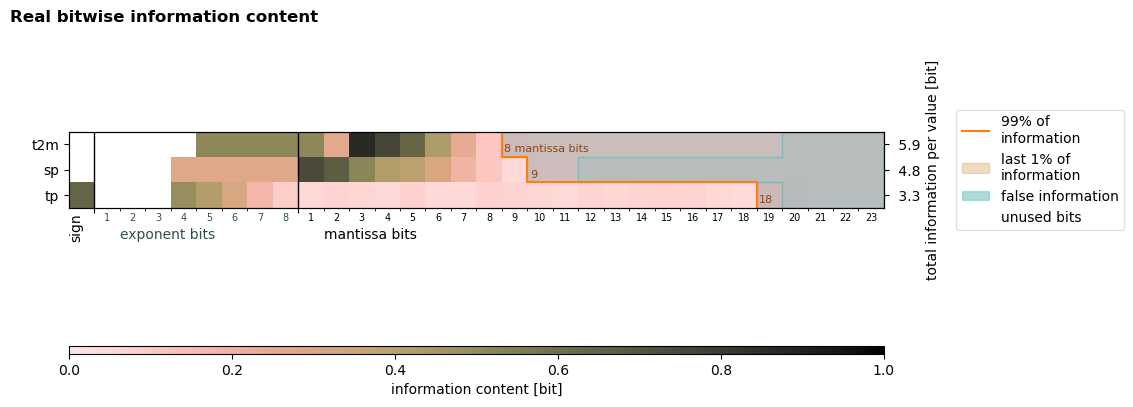

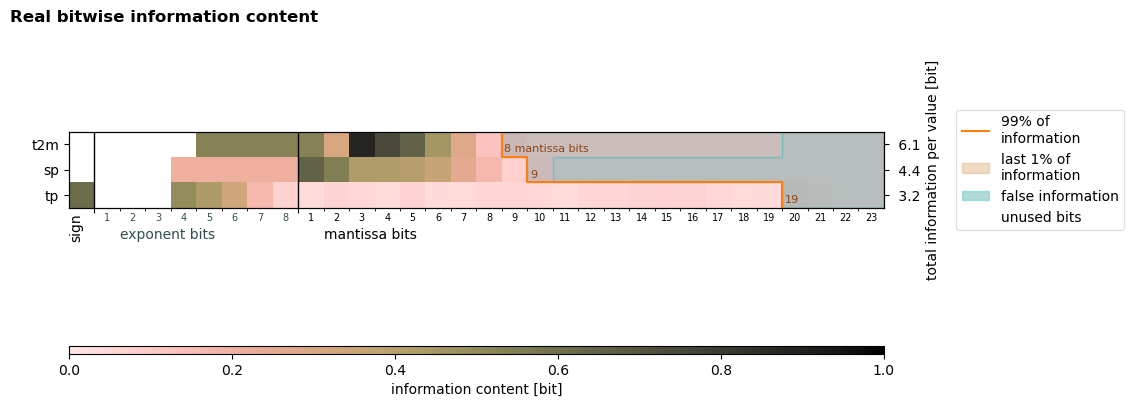

In [9]:
for i in range(PARTS):
    temp_ds = ds.isel(longitude=slice(i*chunk, (i+1)*chunk))
    dss.append(temp_ds)
    temp_info_pbit = xb.get_bitinformation(temp_ds, dim=var, implementation="python")
    fig = xb.plot_bitinformation(temp_info_pbit)
    temp_keepbits = xb.get_keepbits(temp_info_pbit, 0.99)
    temp_ds_bitrounded = xb.xr_bitround(temp_ds, temp_keepbits)
    dss_bitrounded.append(temp_ds_bitrounded) 

In [10]:
utils.save2ncdf(ds, ds_bitrounded)
utils.save2zarr(ds, ds_bitrounded)

In [11]:
sdata = {
    'ncdf': utils.get_size('nc'),
    'zarr': utils.get_size('zarr')
}

In [12]:
sdata

{'ncdf': {'bitr_comp': 1980, 'comp': 1408, 'ori': 6108},
 'zarr': {'bitr_comp': 2580, 'comp': 6264, 'ori': 12392}}

In [13]:
# CLEAN
!rm *.nc
!rm -r *.zarr

---

In [14]:
sdatas = []

In [15]:
for i in range(PARTS):
    utils.save2ncdf(dss[i], dss_bitrounded[i], str(i))
    utils.save2zarr(dss[i], dss_bitrounded[i], str(i))
    temp_sdata = {
        'ncdf': utils.get_size('nc', str(i)),
        'zarr': utils.get_size('zarr', str(i))
    }
    sdatas.append(temp_sdata)

In [16]:
# CLEAN
!rm *.nc
!rm -r *.zarr

In [17]:
sdatas

[{'ncdf': {'bitr_comp': 512, 'comp': 392, 'ori': 1540},
  'zarr': {'bitr_comp': 592, 'comp': 1592, 'ori': 3176}},
 {'ncdf': {'bitr_comp': 512, 'comp': 380, 'ori': 1540},
  'zarr': {'bitr_comp': 588, 'comp': 1576, 'ori': 3176}}]

---

In [18]:
import pandas as pd

df = pd.DataFrame(sdata)
df

,ncdf,zarr
bitr_comp,1980,2580
comp,1408,6264
ori,6108,12392


In [19]:
cum_df = pd.DataFrame()
for i, d in enumerate(sdatas):
    temp_df = pd.DataFrame(sdatas[i])
    temp_df.rename(columns={'ncdf': f'ncdf-{i}', 'zarr': f'zarr-{i}'}, inplace=True)
    cum_df = pd.concat([cum_df, temp_df], axis=1)
    
cum_df

,ncdf-0,zarr-0,ncdf-1,zarr-1
bitr_comp,512,592,512,588
comp,392,1592,380,1576
ori,1540,3176,1540,3176


---

In [20]:
import matplotlib.pyplot as plt

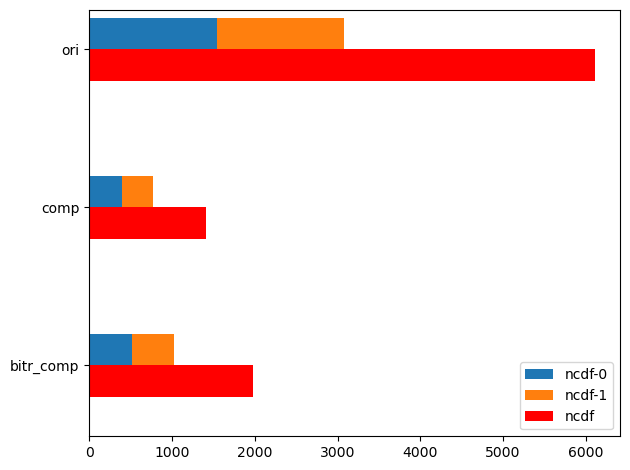

In [21]:
fig, ax = plt.subplots()
cum_df[['ncdf-0', 'ncdf-1']].plot.barh(stacked=True, ax=ax, width=.2, position=0)
df['ncdf'].plot.barh(width=.2, ax=ax, color='red', y='ncdf', position=1, label='ncdf')
ax.legend()
plt.tight_layout()

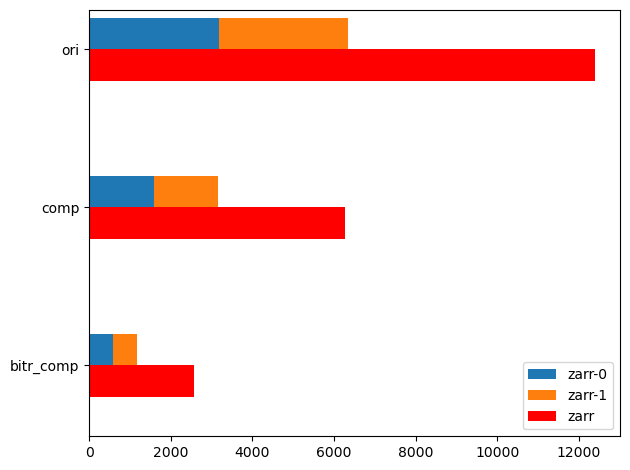

In [22]:
fig, ax = plt.subplots()
cum_df[['zarr-0', 'zarr-1']].plot.barh(stacked=True, ax=ax, width=.2, position=0)
df['zarr'].plot.barh(width=.2, ax=ax, color='red', y='zarr', position=1, label='zarr')
ax.legend()
plt.tight_layout()

---